# Lyell Below Maclure 2019 - 2021 Time Series Stitching 
Joe Ammatelli | 8-10-22

This notebook documents the steps taken to offset and combine postprocessed (trimmed, barocorrected, quality controlled) level/stage time series from multiple years into a single continuous time series. In particular, this notebook faciliates the following steps:
1. Loading the previous published dataset
2. Loading manual stage measurements
3. Loading postprocessed vented time series
4. Loading postprocessed unvented time series
5. Offsetting segments such that they agree with the published data and/or manual stage measurements
6. Stitching of offset time series into a single time series

Once all steps have been completed, a single .csv file with the following quantities will be generated (and will span the entire period from which data was collected). 
* date and time (UTC)
* vented pressure, cm
* raw pressure, cm
* barocorrected pressure, cm
* adjusted stage, cm
* estimated discharge, cms
* water temperature, degrees C
* discharge flag

Author of Template and Underlying Code: Joe Ammatelli | (jamma@uw.edu) | July 2022

## Import Relevant Libraries
**Analyst TODO**: Nothing

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta 

sys.path.insert(0, os.path.abspath(os.path.join('..', '..', 'src')))

import config
import level_baro_utils
import log_utils

sys.path.remove(os.path.abspath(os.path.join('..', '..', 'src')))

## Choose Plotting Backend
**Analyst TODO**:
* Choose plotting backend:
    - Interactive (recommended): uncomment `%matplotlib notebook` and `FIGSIZE=NONE`; comment out `FIGSIZE = config.FIGSIZE`
    - Inline: comment out `%matplotlib notebook` `FIGSIZE=NONE`; uncomment `FIGSIZE = config.FIGSIZE`

In [2]:
%matplotlib notebook
FIGSIZE=None

#FIGSIZE = config.FIGSIZE

sns.set_theme()

## Specify Site Information
**Analyst TODO**:
* assign an integer representing the site to the variable `sitecode`. Mappings are as follows (follows from upstream to downstream):
    * 0 : Lyell Below Maclure
    * 1 : Lyell Above Twin Bridges
    * 2 : Dana Fork at Bug Camp
    * 3 : Tuolumne River at Highway 120
    * 4 : Budd Creek
    * 5 : Delaney Above PCT
* assign an integer (format 'YYYY') representing the first year of data collection to `start_year`
* assign an integer (format 'YYYY') representing the last year of data collection to `end_year`
* assign an string (format 'YY-YY') representing the data collection span in years (i.e. `start_year` to `end_year`) to the variable `span`

These input parameters are used to automatically retrieve the postprocessed data, populate the correct log file, label any plots with relevant site descriptors, and automatically write output with descriptive names. 

In [3]:
# example 
# sitecode = 2
# start_year = 2019
# end_year = 2021
# span = '18-21'

sitecode = 0
start_year = 2019
end_year = 2021
span = '19-21'

## Load All Data
**Analyst TODO**:
The vented and unvented data segments are loaded automatically. However, because the previously published data sets and compiled stage data may have nonstandard names and/or table headers, the previoulsy published data and compiled stage data will need to be loaded manually. 
* Read previously published data set into dataframe
* Read compile stage measurements into dataframe

### Load Previously Published Data Set
**Analyst TODO**:
* Make changes as specified below

In [4]:
# TODO: specify file name (not full path, just name)
fn = 'Lyell_blw_Maclure_timeseries_stage_Q_T_2005_2018.csv'

# correct relative path automatically configured
prev_path = os.path.join('..', '..', 'compiled_data', 'published', fn)

# TODO: change index_col and parse_dates entries as needed
prev_df = pd.read_csv(prev_path, index_col=0, parse_dates=[0], infer_datetime_format=True)

# TODO: select the "adjusted stage" column from the dataframe 
# will need to check .csv file to see what the column label is
prev_stage_ds = prev_df[' stage(cm)']

# Preview selected series to make sure everything looks alright
prev_stage_ds.head()

/Users/jamma/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


date_time(UTC:PDT+7)
2004-07-16 00:00:00     227.69
2004-07-16 00:30:00     240.79
2004-07-16 01:00:00     242.01
2004-07-16 01:30:00     242.93
2004-07-16 02:00:00     244.45
Name:  stage(cm), dtype: object

### Load Manual Stage Measurements
**Analyst TODO**:
* Make changes as specified below (may change depending on how the file is formatted)

In [5]:
# TODO: specify file name (not full path, just name)
fn = 'stage19-21.csv'

# correct relative path automatically configured
stage_path = os.path.join('..', '..', 'compiled_data', 'stage', fn)

# TODO: change parse_dates param as needed
# numbers in the list should correspond to the columns in the table with date time data
manual_stage_df = pd.read_csv(stage_path, parse_dates=[[1,2]], infer_datetime_format=True)

# Perform timezone (PDT --> UTC) and unit (FT --> CM) corrections
# TODO: verify timezone of manual stage measurements, adjust offset as needed
utc_pdt_timedelta = timedelta(hours=7)
manual_stage_df['date_time (pdt)'] += utc_pdt_timedelta
manual_stage_df['stage (ft)'] *= level_baro_utils.FT_TO_CM

# Create dataframe for stage measurements
# TODO: for each entry in the columns dictionary, ensure the lefthand mapping matches the table labels
# e.g. if the compile stage table has columns "date_time (pdt)" and "stage (ft)",
# the columns argument should be {'date_time (pdt)':'date_time(UTC)', 'stage (ft)':'stage(cm)'}
manual_stage_df.rename(columns={'date_time (pdt)':'date_time(UTC)', 'stage (ft)':'stage(cm)'}, inplace=True)
manual_stage_df.set_index('date_time(UTC)', inplace=True)

# Select only the manual stage measurements for the site of interest
# TODO: modify the indexer into manual_stage_df so that it matches the label of the column for the site label
site_manual_stage_df = manual_stage_df[manual_stage_df['site'] == config.SITE_SHORTNAME[sitecode]]
site_manual_stage_df.head()

,site,stage(cm),notes
date_time(UTC),,,
2019-07-03 14:20:00,LyellBlwMaclure,240.7920,NaN
2019-07-03 14:58:00,LyellBlwMaclure,240.4872,NaN
2019-07-03 15:49:00,LyellBlwMaclure,239.2680,NaN
2019-07-03 16:00:00,LyellBlwMaclure,239.2680,NaN
2019-08-06 23:00:00,LyellBlwMaclure,228.9048,NaN


### Load Vented Data
**Analyst TODO**: Nothing

In [6]:
vented_segments = level_baro_utils.read_vented_segments(sitecode)
vented_segments[-1].head()

loading ../../vented/data/processed/LyellBlwMaclure_18-21_vented_0.csv


,vented_pressure(cm),water_temperature(deg_C),discharge_flag
date_time(UTC:PDT+7),,,
2018-06-01 00:00:00,65.80632,4.018,0
2018-06-01 00:30:00,66.20256,3.783,0
2018-06-01 01:00:00,67.48272,3.525,0
2018-06-01 01:30:00,67.11696,3.257,0
2018-06-01 02:00:00,66.32448,2.968,0


### Load Unvented Data
For each year that data is available, load unvented time series data

**Analyst TODO**: Nothing

In [7]:
unvented_segments = level_baro_utils.read_unvented_segments(sitecode, start_year, end_year)

loading ../../unvented_2019/data/barocorrected/LyellBlwMaclure_2019_barocorrected_0.csv
loading ../../unvented_2020/data/barocorrected/LyellBlwMaclure_2020_barocorrected_0.csv
loading ../../unvented_2021/data/barocorrected/LyellBlwMaclure_2021_barocorrected_0.csv


## Plot All Data Together (and develop plan for finding offsets)
**Analyst TODO**: Inspect plot, decide how you are going to compute the offsets for each segment.

<IPython.core.display.Javascript object>


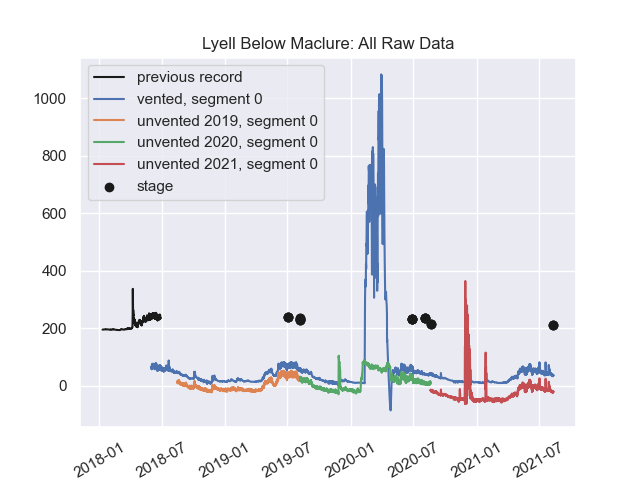

In [8]:
level_baro_utils.plot_all(title=f'{config.SITE_LONGNAME[sitecode]}: All Raw Data', 
                          prev=prev_stage_ds, 
                          stage=site_manual_stage_df, 
                          vented_segments=vented_segments, 
                          unvented_segments=unvented_segments,
                          figsize=FIGSIZE)

## From left to right, find offset of each segment
**Analyst TODO**:
For each segment, compute the offset needed so that the time series matches a portion of an overlapping time series (taken to be "ground truth") and/or fits the manual stage measurements. 
* Initialize offsets (to be zero); this way, we can incrimentally observe how the offset time series look
* Create a new markdown cell and give a discriptive name, e.g. "Find offset between published record and vented series"
* Create a new code cell, compute the difference between the time series and a reference (either vented series, previous overlapping record, or manual stage measurements); visualize the difference (to see if it is roughly constant)
    - Use `dif_btw_series` to generate a series representing the difference between two series at each step
    - Use `dif_btw_stage_series` to generate a series with the difference between a set of manual stage measurements and the corresponding sample from the time series 
* Create a new code cell; filter out members of the difference series as necessary so that the aggregation of is not biased by outliers
* Create a new code cell; reduce the difference time series to a single offset value (mean and/or median are good choices), save in the appropriate entry of the offset data structure
* Create a new code cell: plot the time series with offset (along with any other desired time series for comparison); give descriptive title. Data plotting options (what to display):
    - prev : previously published record
    - stage : manual stage measurements
    - vented_segments : all vented segments
    - unvented_segments : all unvented segments
    - vented_offsets : offsets to apply to vented segments
    - unvented offsets : offsets to apply to unvented segments

**Strategies**
* Start from the past, work toward the present (and use previous records as references)
1. try to find offset between previous record and vented; then find different between each unvented segment and the offset vented series
2. Fit vented/unvented data to stage measurements

### Initialize Offsets

In [9]:
vented_offsets, unvented_offsets = level_baro_utils.initialize_offsets(vented_segments, unvented_segments)

### 1. Find offset between previous record and vented series

<IPython.core.display.Javascript object>


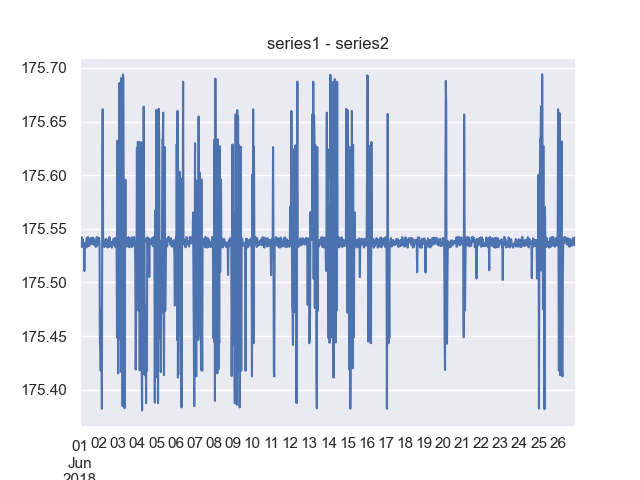

Text(0.5, 1.0, 'series1 - series2')

In [10]:
# find difference between segment and reference (another series or manual stage measurements)
series1 = prev_stage_ds
series2 = vented_segments[0]['vented_pressure(cm)']

dif = level_baro_utils.dif_btw_series(series1, series2)

# visualize differene time series (ideally, it is roughly constant with some noise)
plt.figure()
dif.plot()
plt.title('series1 - series2')

In [11]:
# choose a suitable method for reducing the difference series to a single value (mean, median)
# filter outliers as necessary before reducing
# save to appropriate place in offset data structure
vented_offsets[0] = dif.mean()

<IPython.core.display.Javascript object>


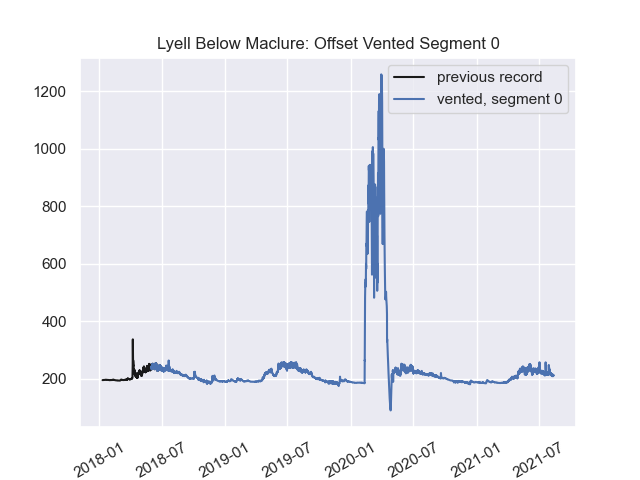

In [12]:
# visualize offset series along with any othe desired data
level_baro_utils.plot_all(title=f'{config.SITE_LONGNAME[sitecode]}: Offset Vented Segment 0',
                          prev=prev_stage_ds, 
                          vented_segments=vented_segments, 
                          vented_offsets=vented_offsets)

### 2. Find offset between offset vented record and and 2019 unvented segment

<IPython.core.display.Javascript object>


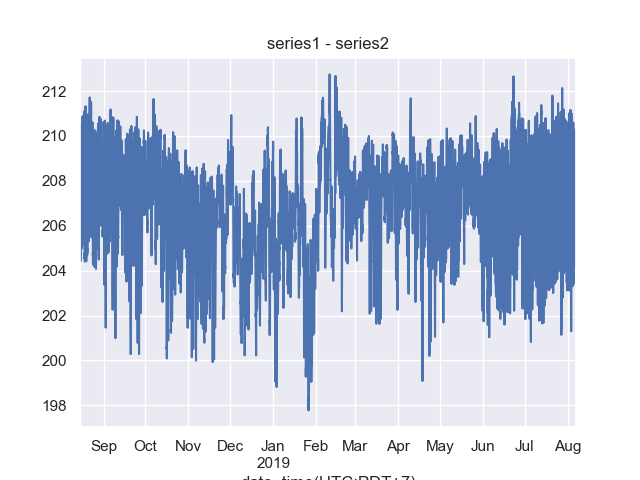

Text(0.5, 1.0, 'series1 - series2')

In [13]:
series1 = vented_segments[0]['vented_pressure(cm)'] + vented_offsets[0]
series2 = unvented_segments[2019][0]['barocorrected_pressure(cm)']

dif = level_baro_utils.dif_btw_series(series1, series2)

plt.figure()
dif.plot()
plt.title('series1 - series2')

In [14]:
# average only differences that are greater than 2.5
unvented_offsets[2019][0] = dif.mean()

<IPython.core.display.Javascript object>


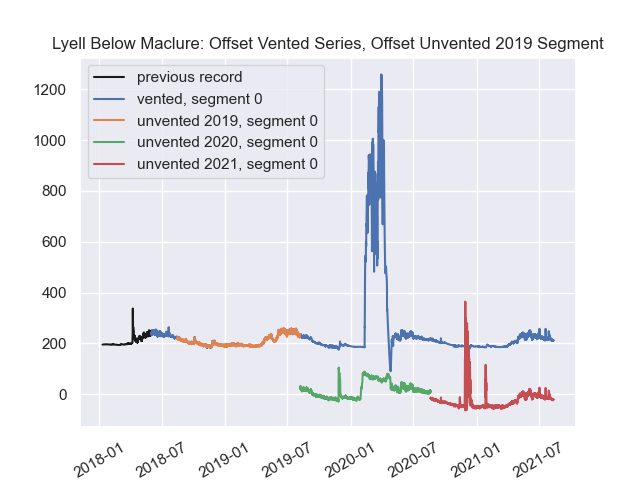

In [15]:
level_baro_utils.plot_all(title=f'{config.SITE_LONGNAME[sitecode]}: Offset Vented Series, Offset Unvented 2019 Segment',
                          prev=prev_stage_ds, 
                          vented_segments=vented_segments, 
                          vented_offsets=vented_offsets, 
                          unvented_segments=unvented_segments, 
                          unvented_offsets=unvented_offsets)

### 3. Find offset between offset vented record and and 2020 unvented segment

<IPython.core.display.Javascript object>


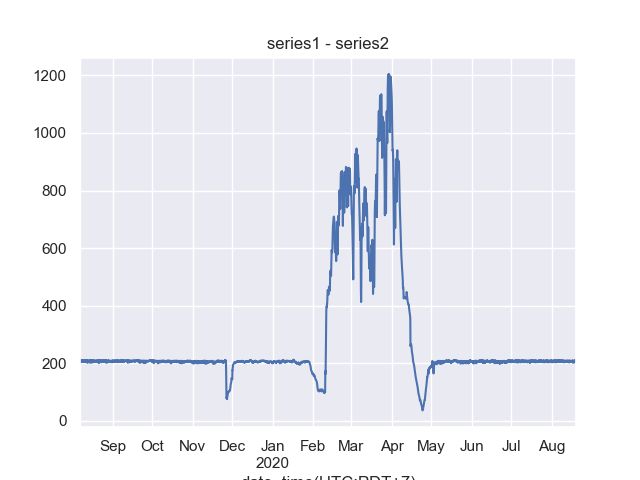

Text(0.5, 1.0, 'series1 - series2')

In [16]:
series1 = vented_segments[0]['vented_pressure(cm)'] + vented_offsets[0]
series2 = unvented_segments[2020][0]['barocorrected_pressure(cm)']

dif = level_baro_utils.dif_btw_series(series1, series2)

plt.figure()
dif.plot()
plt.title('series1 - series2')

In [17]:
unvented_offsets[2020][0] = dif[(dif > 195) & (dif < 215)].mean()

<IPython.core.display.Javascript object>


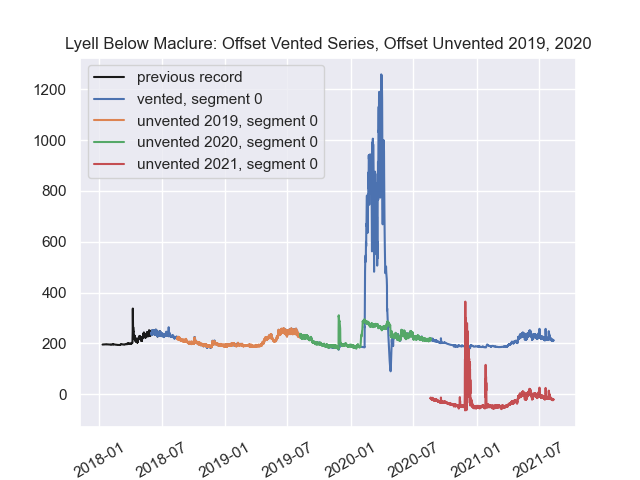

In [18]:
level_baro_utils.plot_all(title=f'{config.SITE_LONGNAME[sitecode]}: Offset Vented Series, Offset Unvented 2019, 2020',
                          prev=prev_stage_ds, 
                          vented_segments=vented_segments, 
                          vented_offsets=vented_offsets, 
                          unvented_segments=unvented_segments, 
                          unvented_offsets=unvented_offsets)

### 4. Find offset between offset vented record and and 2021 unvented segment

<IPython.core.display.Javascript object>


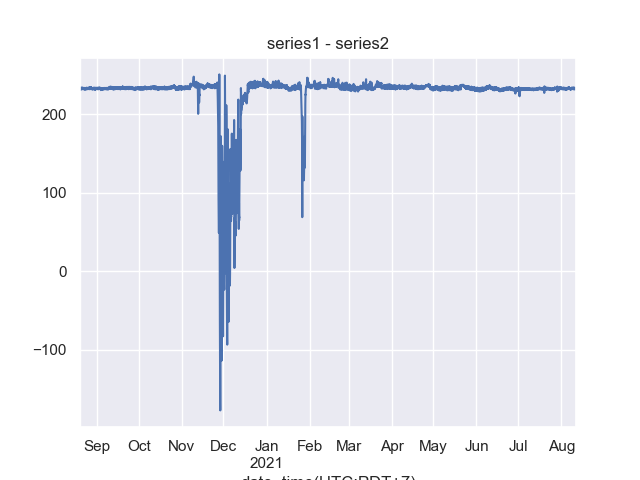

Text(0.5, 1.0, 'series1 - series2')

In [19]:
series1 = vented_segments[0]['vented_pressure(cm)'] + vented_offsets[0]
series2 = unvented_segments[2021][0]['barocorrected_pressure(cm)']

dif = level_baro_utils.dif_btw_series(series1, series2)

plt.figure()
dif.plot()
plt.title('series1 - series2')

In [20]:
unvented_offsets[2021][0] = dif[dif > 225].mean()

<IPython.core.display.Javascript object>


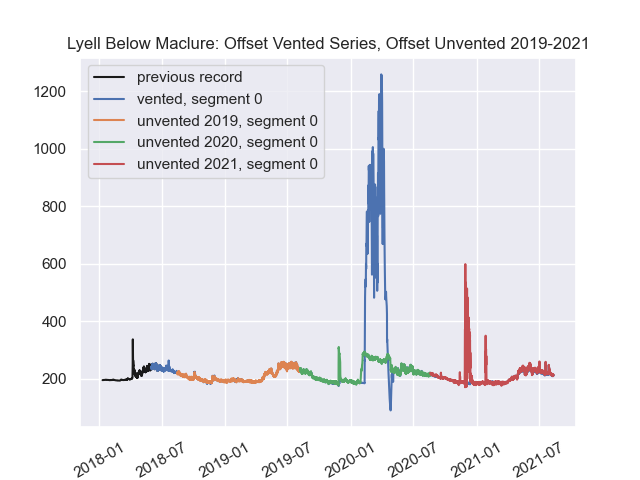

In [21]:
level_baro_utils.plot_all(title=f'{config.SITE_LONGNAME[sitecode]}: Offset Vented Series, Offset Unvented 2019-2021',
                          prev=prev_stage_ds, 
                          vented_segments=vented_segments, 
                          vented_offsets=vented_offsets, 
                          unvented_segments=unvented_segments, 
                          unvented_offsets=unvented_offsets)

## Manually Apply Corrections as Needed
**Analyst TODO**:
* Manually change offset values if computed values are clearly incorrect

In [22]:
unvented_offsets[2021][0] = unvented_offsets[2021][0] - 1

<IPython.core.display.Javascript object>


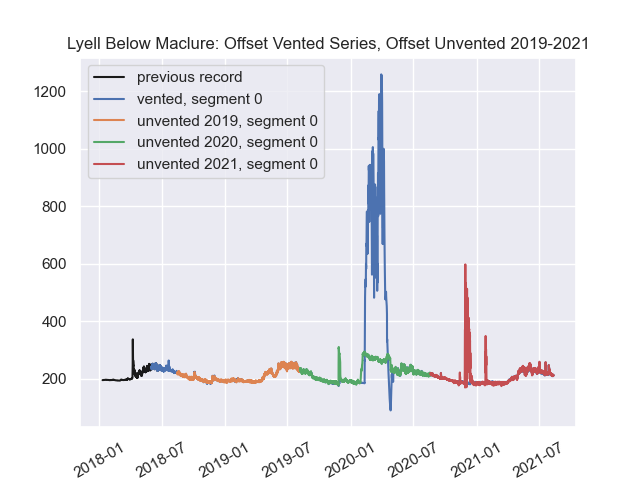

In [23]:
level_baro_utils.plot_all(title=f'{config.SITE_LONGNAME[sitecode]}: Offset Vented Series, Offset Unvented 2019-2021',
                          prev=prev_stage_ds, 
                          vented_segments=vented_segments, 
                          vented_offsets=vented_offsets, 
                          unvented_segments=unvented_segments, 
                          unvented_offsets=unvented_offsets)

## Create time series for entire period: select segments to use for time series, add offsets
**Analyst TODO**:
* Specify which segments to string together
    - create a list of lists; for each inner list, provide: segment, when to start using the segment in the stitched series, and the offset
    - e.g.: ```segments = [[vented_segments[0], vented_segments[0].index[0], vented_offsets[0]],[unvented_segments[2019][0], unvented_segments[2019][0].index[0], unvented_offsets[2019][0]],[unvented_segments[2021][0], unvented_segments[2021][0].index[0], unvented_offsets[2021][0]],[unvented_segments[2021][1], unvented_segments[2021][1].index[0],unvented_offsets[2021][1]]] ```corresponds to using the vented time series for the first segment of the stitched time series (from the beginning of the vented record to the beginning of next segment), using the 0th segment of the unvented 2019 data for the second segment of the stitched time series (from the start of the 2019 segment 0 record to the start of the next record) and so forth). 
          
Once the segments are specified, they can be automatically joined using `level_baro_utils.stitch_timeseries` and passing the segments list

In [24]:
# example
# segments = [[vented_segments[0], vented_segments[0].index[0], vented_offsets[0], 'vented_pressure(cm)'],
#             [unvented_segments[2019][0], unvented_segments[2019][0].index[0], unvented_offsets[2019][0]],
#             [unvented_segments[2021][0], unvented_segments[2021][0].index[0], unvented_offsets[2021][0]],
#             [unvented_segments[2021][1], unvented_segments[2021][1].index[0], unvented_offsets[2021][1]]]

segments = [[vented_segments[0], vented_segments[0].index[0], vented_offsets[0]]]

stitched_df = level_baro_utils.stitch_timeseries(segments)

/Users/jamma/Desktop/TuolumneHydroClimate/src/level_baro_utils.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment['adjusted_stage(cm)'] = offset_series


### Inspect Stitched Time Series

<IPython.core.display.Javascript object>


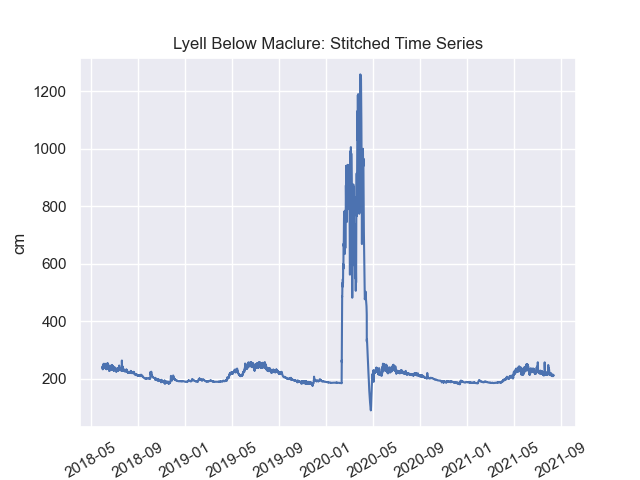

,raw_pressure(cm),barocorrected_pressure(cm),adjusted_stage(cm),estimated_discharge(cms),water_temperature(deg_C),discharge_flag
date_time(UTC:PDT+7),,,,,,
2018-06-01 00:00:00,65.80632,65.80632,241.341155,NaN,4.018,0
2018-06-01 00:30:00,66.20256,66.20256,241.737395,NaN,3.783,0
2018-06-01 01:00:00,67.48272,67.48272,243.017555,NaN,3.525,0
2018-06-01 01:30:00,67.11696,67.11696,242.651795,NaN,3.257,0
2018-06-01 02:00:00,66.32448,66.32448,241.859315,NaN,2.968,0


In [25]:
plt.figure()
plt.plot(stitched_df['adjusted_stage(cm)'])
plt.xticks(rotation=30)
plt.ylabel('cm')
plt.title(f'{config.SITE_LONGNAME[sitecode]}: Stitched Time Series')

stitched_df.head()

## Generate discharge time series using rating curve
**Analyst TODO**: Ensure rating curve up to data (update in config if necessary), inspect result

In [26]:
stitched_df['estimated_discharge(cms)'] = level_baro_utils.compute_discharge(stitched_df['adjusted_stage(cm)'], sitecode)

<IPython.core.display.Javascript object>


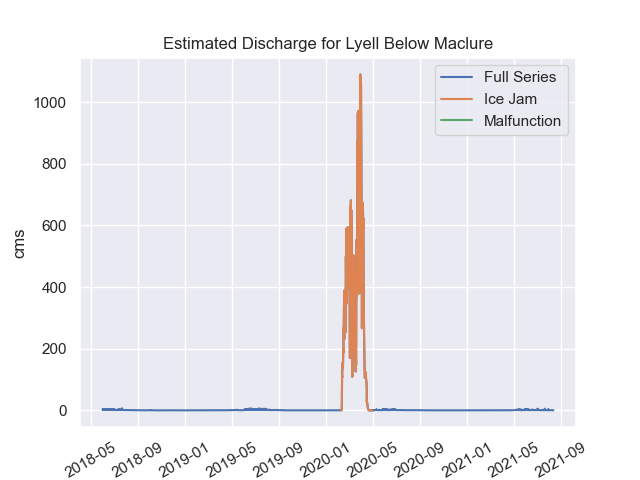

,raw_pressure(cm),barocorrected_pressure(cm),adjusted_stage(cm),estimated_discharge(cms),water_temperature(deg_C),discharge_flag
date_time(UTC:PDT+7),,,,,,
2018-06-01 00:00:00,65.80632,65.80632,241.341155,2.548146,4.018,0
2018-06-01 00:30:00,66.20256,66.20256,241.737395,2.606281,3.783,0
2018-06-01 01:00:00,67.48272,67.48272,243.017555,2.797776,3.525,0
2018-06-01 01:30:00,67.11696,67.11696,242.651795,2.742493,3.257,0
2018-06-01 02:00:00,66.32448,66.32448,241.859315,2.624277,2.968,0


In [27]:
level_baro_utils.plot_discharge(stitched_df, sitecode)

stitched_df.head()

## Write Output to File
**Analyst TODO**: Nothing to change

In [28]:
level_baro_utils.save_final_data(stitched_df, sitecode, start_year, end_year)

Wrote data to ../data/processed/LyellBlwMaclure_timeseries_stage_Q_T_2019_2021.csv
